In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"Số GPU: {torch.cuda.device_count()}")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU name: NVIDIA GeForce RTX 3070 Laptop GPU
Số GPU: 1


# Hàm Load dataa

In [2]:
class SequentialCourseDataset(Dataset):
    def __init__(self, X, mask, y=None):
        self.X = torch.FloatTensor(X)
        self.mask = torch.BoolTensor(mask)
        self.lengths = mask.sum(axis=1).astype(np.int32)
        self.y = torch.LongTensor(y) if y is not None else None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        item = {
            'X': self.X[idx],
            'length': torch.tensor(self.lengths[idx]),
            'mask': self.mask[idx]
        }
        if self.y is not None:
            item['y'] = self.y[idx]
        return item

In [ ]:
class ImprovedBiLSTM(nn.Module):
    def __init__(self, input_dim=38, hidden_dim=256, num_layers=4, dropout=0.5, num_classes=5):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        forward_h = hn[-2]   # last forward
        backward_h = hn[-1]  # last backward
        combined = torch.cat([forward_h, backward_h], dim=1)
        combined = self.dropout(combined)
        logits = self.fc(combined)
        return logits

# Load data


In [4]:

TRAIN_PATH = r"/home/check/DATA/university/yr3, hk1/DS317 - Khai phá dữ liệu trong doanh nghiệp/3 Do an cuoi ky/data/course_train.npz"
TEST_PATH  = r"/home/check/DATA/university/yr3, hk1/DS317 - Khai phá dữ liệu trong doanh nghiệp/3 Do an cuoi ky/data/course_test.npz"


data_train = np.load(TRAIN_PATH, allow_pickle=True)
X_train_full = data_train['X']
mask_train_full = data_train['mask']
y_train_full = data_train['y']

data_test = np.load(TEST_PATH, allow_pickle=True)
X_test = data_test['X']
mask_test = data_test['mask']
y_test = data_test['y']

print(f"Train full: X {X_train_full.shape}, mask {mask_train_full.shape}, y {y_train_full.shape}")
print(f"Test     : X {X_test.shape}, mask {mask_test.shape}, y {y_test.shape}")

Train full: X (105180, 70, 38), mask (105180, 70), y (105180,)
Test     : X (25534, 70, 38), mask (25534, 70), y (25534,)


In [5]:
# === CELL MỚI: FIX NHÃN Y (CHẠY SAU CELL LOAD DATA) ===

# In nhãn gốc để confirm
print("Nhãn gốc (train): min =", y_train_full.min(), "max =", y_train_full.max())
print("Unique nhãn gốc (train):", np.unique(y_train_full))

# TRỪ 1 ĐỂ MAP 1-5 → 0-4
y_train_full = y_train_full - 1
y_test = y_test - 1

# Confirm lại
print("Sau khi fix (train): min =", y_train_full.min(), "max =", y_train_full.max())
print("Unique sau fix (train):", np.unique(y_train_full))
print("Unique sau fix (test):", np.unique(y_test))

# Bây giờ y là int từ 0 đến 4 → an toàn cho CrossEntropyLoss
y_train_full = y_train_full.astype(np.int64)
y_test = y_test.astype(np.int64)

Nhãn gốc (train): min = 1.0 max = 5.0
Unique nhãn gốc (train): [1. 2. 3. 4. 5.]
Sau khi fix (train): min = 0.0 max = 4.0
Unique sau fix (train): [0. 1. 2. 3. 4.]
Unique sau fix (test): [0. 1. 2. 3. 4.]


In [6]:
# Chia 10% từ train làm validation
X_train, X_val, mask_train, mask_val, y_train, y_val = train_test_split(
    X_train_full, mask_train_full, y_train_full,
    test_size=0.1, random_state=42, stratify=y_train_full
)

# Scaling dựa trên train
scaler = StandardScaler()
n_samples, timesteps, n_features = X_train.shape

X_train_reshaped = X_train.reshape(-1, n_features)
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)

X_val_reshaped = X_val.reshape(-1, n_features)
X_val_scaled = scaler.transform(X_val_reshaped).reshape(X_val.shape)

X_test_reshaped = X_test.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

print("Scaling hoàn tất!")
print(f"Train scaled: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")

Scaling hoàn tất!
Train scaled: (94662, 70, 38), Val: (10518, 70, 38), Test: (25534, 70, 38)


In [7]:
batch_size = 256  

train_dataset = SequentialCourseDataset(X_train_scaled, mask_train, y_train)
val_dataset   = SequentialCourseDataset(X_val_scaled,   mask_val,   y_val)
test_dataset  = SequentialCourseDataset(X_test_scaled,  mask_test,  y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=8, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

print(f"Số batch: Train {len(train_loader)}, Val {len(val_loader)}, Test {len(test_loader)}")

Số batch: Train 370, Val 42, Test 100


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = ImprovedBiLSTM(
    input_dim=38,
    hidden_dim=256,   
    num_layers=3,     
    dropout=0.5,       
    num_classes=5
).to(device)

# Nếu có nhiều GPU
if torch.cuda.device_count() > 1:
    print(f"Sử dụng {torch.cuda.device_count()} GPUs với DataParallel!")
    model = nn.DataParallel(model)

model = model.to(device)
y_train_int = y_train.astype(int) 


unique_classes = np.unique(y_train_int)
print("Các lớp thực tế trong train:", unique_classes) 

class_counts = np.zeros(5)  
for i in range(5):
    class_counts[i] = np.sum(y_train_int == i+1)

print("Số mẫu mỗi lớp (1→5):", class_counts.astype(int))

class_counts = np.bincount(y_train)  
print("Số mẫu mỗi lớp (0→4 tương ứng cũ 1→5):", class_counts)


class_counts = np.where(class_counts == 0, 1, class_counts)  

class_weights = 1.0 / torch.FloatTensor(class_counts ** 0.5)  
class_weights = class_weights / class_weights.sum() * 5
class_weights = class_weights.to(device)

print("Class weights:", np.round(class_weights.cpu().numpy(), 3))

criterion = FocalLoss(alpha=class_weights, gamma=2.0)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.5, verbose=True)

Using device: cuda
Các lớp thực tế trong train: [0 1 2 3 4]
Số mẫu mỗi lớp (1→5): [27652  6406 16870  8347     0]
Số mẫu mỗi lớp (0→4 tương ứng cũ 1→5): [35387 27652  6406 16870  8347]
Class weights: [0.626 0.708 1.471 0.906 1.289]


In [11]:
torch.cuda.empty_cache()

# Finetune & train

In [12]:
epochs = 10
train_losses = []
val_losses = []
best_val_f1 = 0.0
patience = 5
wait = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        x = batch['X'].to(device)
        lengths = batch['length'].to(device)
        y = batch['y'].to(device)
        
        logits = model(x, lengths)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    preds = []
    trues = []
    with torch.no_grad():
        for batch in val_loader:
            x = batch['X'].to(device)
            lengths = batch['length'].to(device)
            y = batch['y'].to(device)
            logits = model(x, lengths)
            loss = criterion(logits, y)
            val_loss += loss.item()
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            trues.extend(y.cpu().numpy())
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss   = val_loss   / len(val_loader)
    val_acc = accuracy_score(trues, preds)
    val_macro_f1 = f1_score(trues, preds, average='macro')
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
          f"| Val Acc: {val_acc:.4f} | Val Macro F1: {val_macro_f1:.4f}")
    
    scheduler.step(avg_val_loss)
    
    # Save best model theo Macro F1
    if val_macro_f1 > best_val_f1:
        best_val_f1 = val_macro_f1
        torch.save(model.state_dict(), 'best_bilstm_model.pth')
        joblib.dump(scaler, 'bilstm_scaler.pkl')
        wait = 0
        print("  → Saved new best model!")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered!")
            break

print("Training hoàn tất!")

Epoch 01 | Train Loss: 0.2496 | Val Loss: 0.1814 | Val Acc: 0.6580 | Val Macro F1: 0.6097
  → Saved new best model!
Epoch 02 | Train Loss: 0.1564 | Val Loss: 0.1264 | Val Acc: 0.7727 | Val Macro F1: 0.7276
  → Saved new best model!
Epoch 03 | Train Loss: 0.1211 | Val Loss: 0.1053 | Val Acc: 0.7881 | Val Macro F1: 0.7529
  → Saved new best model!
Epoch 04 | Train Loss: 0.0998 | Val Loss: 0.0836 | Val Acc: 0.8379 | Val Macro F1: 0.8147
  → Saved new best model!
Epoch 05 | Train Loss: 0.0822 | Val Loss: 0.0677 | Val Acc: 0.8872 | Val Macro F1: 0.8612
  → Saved new best model!
Epoch 06 | Train Loss: 0.0736 | Val Loss: 0.0581 | Val Acc: 0.8961 | Val Macro F1: 0.8725
  → Saved new best model!
Epoch 07 | Train Loss: 0.0697 | Val Loss: 0.0546 | Val Acc: 0.8834 | Val Macro F1: 0.8632
Epoch 08 | Train Loss: 0.0610 | Val Loss: 0.0551 | Val Acc: 0.9287 | Val Macro F1: 0.9084
  → Saved new best model!
Epoch 09 | Train Loss: 0.0559 | Val Loss: 0.0399 | Val Acc: 0.9166 | Val Macro F1: 0.8969
Epoch 10

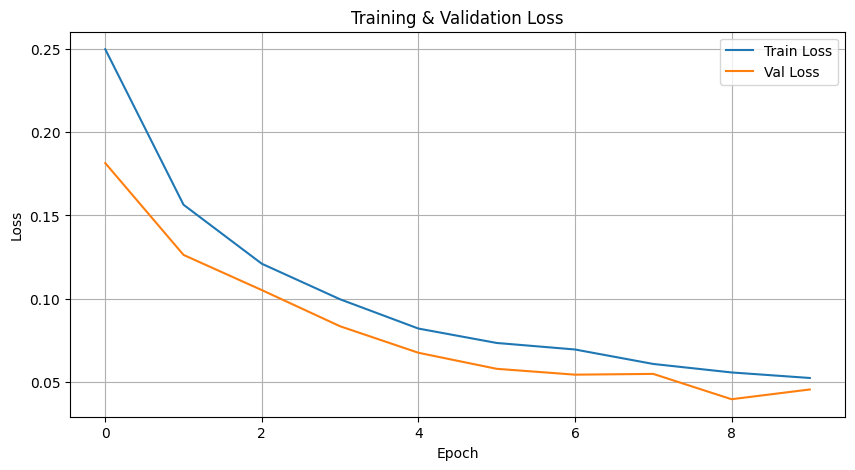

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Load best model
model.load_state_dict(torch.load('best_bilstm_model.pth'))
model.eval()

preds_test = []
with torch.no_grad():
    for batch in test_loader:
        x = batch['X'].to(device)
        lengths = batch['length'].to(device)
        logits = model(x, lengths)
        preds_test.extend(torch.argmax(logits, dim=1).cpu().numpy())

preds_test = np.array(preds_test)

print("=== KẾT QUẢ CUỐI CÙNG TRÊN TEST SET ===")
print(f"Accuracy       : {accuracy_score(y_test, preds_test):.4f}")
print(f"Macro F1       : {f1_score(y_test, preds_test, average='macro'):.4f}")
print(f"Weighted F1    : {f1_score(y_test, preds_test, average='weighted'):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, preds_test, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds_test))

# Lưu kết quả
results = {
    'predictions': preds_test,
    'true_labels': y_test
}
joblib.dump(results, 'bilstm_final_results.pkl')
print("\nĐã lưu predictions và scaler!")

=== KẾT QUẢ CUỐI CÙNG TRÊN TEST SET ===
Accuracy       : 0.5987
Macro F1       : 0.5025
Weighted F1    : 0.6082

Classification Report:
              precision    recall  f1-score   support

           0     0.7709    0.7342    0.7521      9266
           1     0.7320    0.6793    0.7047      7310
           2     0.1843    0.3076    0.2305      1492
           3     0.4145    0.3960    0.4050      4773
           4     0.4070    0.4345    0.4203      2693

    accuracy                         0.5987     25534
   macro avg     0.5017    0.5103    0.5025     25534
weighted avg     0.6205    0.5987    0.6082     25534


Confusion Matrix:
[[6803    0  784 1679    0]
 [   0 4966  464  458 1422]
 [ 618   86  459  259   70]
 [1404  612  654 1890  213]
 [   0 1120  129  274 1170]]

Đã lưu predictions và scaler!
